In [1]:
import sys
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np

sys.path.append("/Users/martinedh/Documents/NTNU/GitHub/FysMat/Prosjektoppgave")
from main import solve_and_return_system_and_F_matrix

from main import define_system, solve_and_test_small_system, solve_for_sns_system, solve_for_sfs_system
from plots import plot_pairing_amplitude, plot_density_of_states

from solve_hamiltonian import solve_system

<h2> Current for one system of SNS. Test to see if current is constant.
Also: Test for runtime and convergance

In [2]:
%%time

# record runtime@
import timeit
start = timeit.default_timer()


system, F_matrix = solve_and_test_small_system(max_num_iter=1, tol=1e10)

# print runtime
stop = timeit.default_timer()
print('Time: ', stop - start) 

num iteration is  1
Time:  73.78451967297588
CPU times: user 54.5 s, sys: 1.41 s, total: 55.9 s
Wall time: 1min 13s


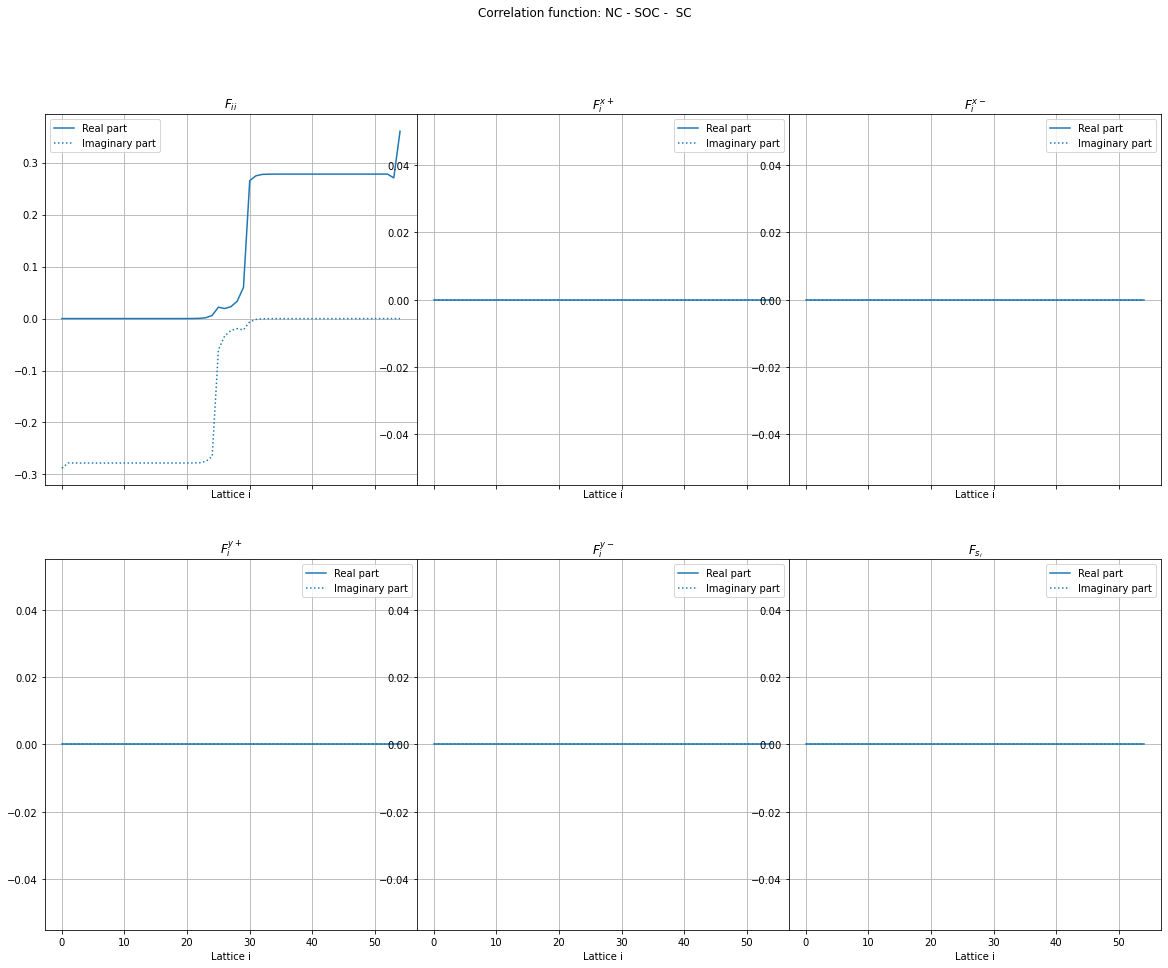

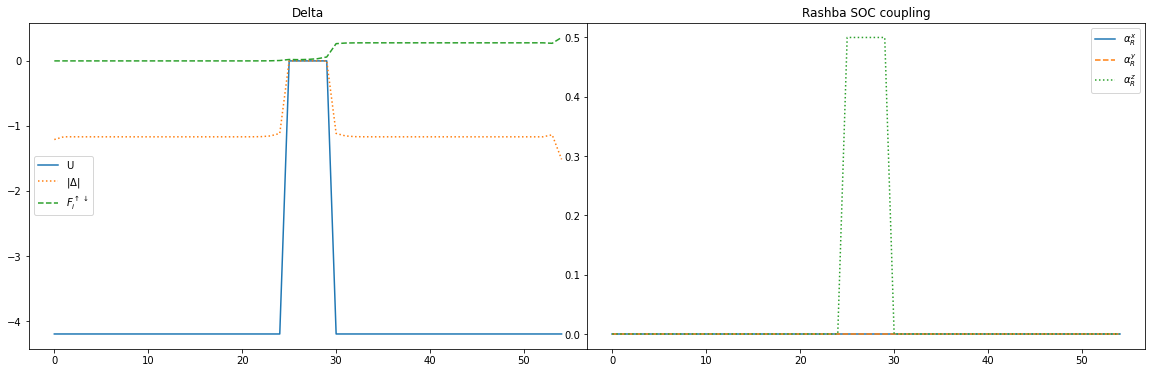

In [3]:
plot_pairing_amplitude(system, system.F_matrix) 
# it 1: diff 80.31784729526646
# it 2: diff 13.608228168595833

In [4]:
%%time 

#current = current_along_lattice(system)

# prøv denne og se om du fremdeles får en strøm om går hardt til null i sc
import time
start = time.time()
current = system.current_along_lattice()
print(time.time()-start)

6.475326776504517
CPU times: user 3.79 s, sys: 51.6 ms, total: 3.84 s
Wall time: 6.49 s


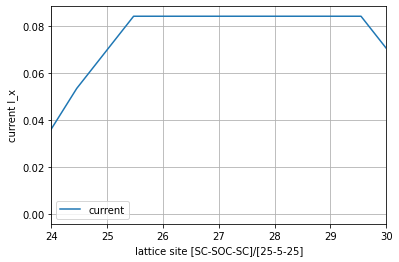

In [11]:
site_x = np.linspace(0, system.L_x-1, system.L_x-1)
#plt.plot(site_x, np.real(current), label="real")
plt.plot(site_x[1:], np.real(current)[1:], label="current")
plt.legend()
plt.xlabel("lattice site [SC-SOC-SC]/[25-5-25]")
plt.ylabel("current I_x")
plt.xlim(24,30)
#plt.ylim(0.0163,0.0169)
plt.grid()
#plt.savefig('current_soc_iter=2000_LzLy=30_12_2_2021.png', dpi=200, bbox_inches='tight')
plt.show()

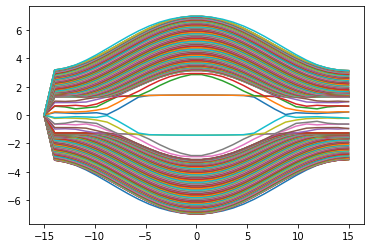

In [6]:
x_tmp = np.linspace(-15, 15, system.eigenvalues.shape[1])
for i in range(system.eigenvalues.shape[0]):
    plt.plot(x_tmp, system.eigenvalues[i, :, 15])
plt.show()

In [7]:
for ky_idx in range(1, len(ky_array)): # form k=-pi to k=pi  #prange, set 1/2-2020
    for kz_idx in range(1, len(kz_array)):
        ham = system.hamiltonian[:,:, ky_idx, kz_idx]
        is_hermitian = np.allclose(np.zeros_like(ham), ham - ham.T.conjugate(), rtol=0.000, atol=1e-4)
        if is_hermitian == False:
            print("First: Hamiltonian is not Hermitian for ", ky_idx, kz_idx)
print(is_hermitian)

NameError: name 'ky_array' is not defined

In [20]:
system.eigenvalues[system.eigenvalues > 1e100] = system.eigenvalues[system.eigenvalues > 1e100]/system.eigenvalues[system.eigenvalues > 1e100]

In [22]:
system.eigenvalues[system.eigenvalues < -1e100] = system.eigenvalues[system.eigenvalues < -1e100]/system.eigenvalues[system.eigenvalues < -1e100]

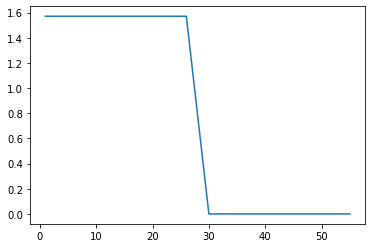

In [8]:
plt.plot(np.linspace(1,len(system.phase_array),len(system.phase_array)), system.phase_array)

In [30]:
print(system.phase_array)

[-1.57079633 -1.57079633 -1.57079633 -1.57079633 -1.57079633 -1.57079633
 -1.57079633 -1.57079633 -1.57079633 -1.57079633 -1.57079633 -1.57079633
 -1.57079633 -1.57079633 -1.57079633 -1.57079633 -1.57079633 -1.57079633
 -1.57079633 -1.57079633 -1.57079633 -1.57079633 -1.57079633 -1.57079633
 -1.57079633 -1.57079633 -1.3962634  -1.22173048 -1.04719755 -0.87266463
 -0.6981317  -0.52359878 -0.34906585 -0.17453293  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]


In [6]:
from system_helper import current_along_lattice

start = time.time()
current_numba = current_along_lattice(system.L_x, system.L_y, system.L_z, system.L_sc_0, system.L_soc, system.beta, system.t, system.alpha_R_x_array, system.eigenvalues, system.eigenvectors)
print(time.time()-start)

In [66]:
def current_along_lattice_jp(system):
    I = 1.0j
    current = np.zeros(system.L_x - 1, dtype=np.complex128)
    tanh_coeff = 1 / (np.exp(system.beta * system.eigenvalues) + 1)
    tanh_coeff /= (system.L_y * system.L_z) # 1/(system.L_y*system.L_z) *(1-np.tanh(system.beta * system.eigenvalues / 2)) #-

    t = system.t_0
    
    B_matrix_y = np.zeros((4,4))
    B_matrix_y[0,0] = 1
    B_matrix_y[1,1] = -1
    B_matrix_y[2,2] = 1
    B_matrix_y[3,3] = -1
    
    B_matrix_z = np.zeros((4,4), dtype=np.complex128)
    B_matrix_z[0,1] = -1.0j
    B_matrix_z[1,0] = 1.0j
    B_matrix_z[2,3] = 1.0j
    B_matrix_z[3,2] = -1.0j
    
    print(np.linalg.norm(system.alpha_R_x_array[30, :]))

    for ix in range(1, len(current)):  # -1 because it doesnt give sense to check last point for I+
        xi_ii = 0
        xi_minus = 0
        xi_pluss = 0

        #"""
        if (system.L_sc_0 <= ix < (system.L_sc_0 + system.L_soc)): #check if both i and i are inside soc material
            xi_ii = 1
        if (system.L_sc_0 <= ix < (system.L_sc_0 + system.L_soc)):# and (system.L_sc_0 <= ix+1 < (system.L_sc_0 + system.L_soc)):# and (system.L_sc_0 <= ix-1 < (system.L_sc_0 + system.L_soc)): #check if both i and i+1 are inside soc material
            xi_pluss = 1
        if (system.L_sc_0 <= ix < (system.L_sc_0 + system.L_soc)):# and (system.L_sc_0 <= ix-1 < (system.L_sc_0 + system.L_soc)):# and (system.L_sc_0 <= ix+1 < (system.L_sc_0 + system.L_soc)): #check if both i and i-1 are inside soc material
            xi_minus = 1
        #"""
        #if (system.L_sc_0 <= ix < (system.L_sc_0 + system.L_soc) and system.L_sc_0 <= ix+1 < (system.L_sc_0 + system.L_soc) and system.L_sc_0 <= ix-1 < (system.L_sc_0 + system.L_soc)): #check if both i and i are inside soc material
        #    xi_ii = 1
        """
        B_opp_opp_psite = 1.0j / 4 * (1 + xi_ii) * np.linalg.norm(system.alpha_R_x_array[ix, :])
        B_opp_opp_pluss = 1.0j / 4 * (1 + xi_pluss) * np.linalg.norm(system.alpha_R_x_array[ix+1, :])
        B_opp_opp_minus = 1.0j / 4 * (1 + xi_minus) * np.linalg.norm(system.alpha_R_x_array[ix-1, :])
        B_opp_opp_msite = 1.0j / 4 * (1 + xi_ii) * np.linalg.norm(system.alpha_R_x_array[ix, :])
        
        B_ned_ned_psite = - 1.0j / 4 * (1 + xi_ii) * np.linalg.norm(system.alpha_R_x_array[ix, :])
        B_ned_ned_pluss = - 1.0j / 4 * (1 + xi_pluss) * np.linalg.norm(system.alpha_R_x_array[ix+1, :])
        B_ned_ned_minus = - 1.0j / 4 * (1 + xi_minus) * np.linalg.norm(system.alpha_R_x_array[ix-1, :])
        B_ned_ned_msite = - 1.0j / 4 * (1 + xi_ii) * np.linalg.norm(system.alpha_R_x_array[ix, :])
        
        B_opp_ned_psite = - 1.0j / 4 * (1 + xi_ii) * np.linalg.norm(system.alpha_R_x_array[ix, :])
        B_opp_ned_pluss = - 1.0j / 4 * (1 + xi_pluss) * np.linalg.norm(system.alpha_R_x_array[ix+1, :])
        B_opp_ned_minus = - 1.0j / 4 * (1 + xi_minus) * np.linalg.norm(system.alpha_R_x_array[ix-1, :])
        B_opp_ned_msite = - 1.0j / 4 * (1 + xi_ii) * np.linalg.norm(system.alpha_R_x_array[ix, :])
        
        B_ned_opp_psite = + 1.0j / 4 * (1 + xi_ii) * np.linalg.norm(system.alpha_R_x_array[ix, :])
        B_ned_opp_pluss = + 1.0j / 4 * (1 + xi_pluss) * np.linalg.norm(system.alpha_R_x_array[ix+1, :])
        B_ned_opp_minus = + 1.0j / 4 * (1 + xi_minus) * np.linalg.norm(system.alpha_R_x_array[ix-1, :])
        B_ned_opp_msite = + 1.0j / 4 * (1 + xi_ii) * np.linalg.norm(system.alpha_R_x_array[ix, :])
        """
        B_opp_opp_psite = 1.0j / 4 * system.alpha_R_x_array[ix, 1] * (1 + xi_ii)
        B_opp_opp_pluss = 1.0j / 4 * system.alpha_R_x_array[ix+1, 1] * (1 + xi_pluss)
        B_opp_opp_minus = 1.0j / 4 * system.alpha_R_x_array[ix-1, 1] * (1 + xi_minus)
        B_opp_opp_msite = 1.0j / 4 * system.alpha_R_x_array[ix, 1] * (1 + xi_ii)
        
        B_ned_ned_psite = - 1.0j / 4 * system.alpha_R_x_array[ix, 1] * (1 + xi_ii)
        B_ned_ned_pluss = - 1.0j / 4 * system.alpha_R_x_array[ix+1, 1] * (1 + xi_pluss)
        B_ned_ned_minus = - 1.0j / 4 * system.alpha_R_x_array[ix-1, 1] * (1 + xi_minus)
        B_ned_ned_msite = - 1.0j / 4 * system.alpha_R_x_array[ix, 1] * (1 + xi_ii)
        
        B_opp_ned_psite = - 1.0 / 4 * system.alpha_R_x_array[ix, 2] * (1 + xi_ii)
        B_opp_ned_pluss = - 1.0 / 4 * system.alpha_R_x_array[ix+1, 2] * (1 + xi_pluss)
        B_opp_ned_minus = - 1.0 / 4 * system.alpha_R_x_array[ix-1, 2] * (1 + xi_minus)
        B_opp_ned_msite = - 1.0 / 4 * system.alpha_R_x_array[ix, 2] * (1 + xi_ii)
        
        B_ned_opp_psite = + 1.0 / 4 * system.alpha_R_x_array[ix, 2] * (1 + xi_ii)
        B_ned_opp_pluss = + 1.0 / 4 * system.alpha_R_x_array[ix+1, 2] * (1 + xi_pluss)
        B_ned_opp_minus = + 1.0 / 4 * system.alpha_R_x_array[ix-1, 2] * (1 + xi_minus)
        B_ned_opp_msite = + 1.0 / 4 * system.alpha_R_x_array[ix, 2] * (1 + xi_ii)
      
        #B_psite = 0.0 + I / 4 * (system.alpha_R_x_array[ix, 1] + 1.0j * system.alpha_R_x_array[ix, 2]) * (1+xi_pluss)#(1+xi_ii)
        #B_pluss = 0.0 + I / 4 * (system.alpha_R_x_array[ix+1, 1] + 1.0j * system.alpha_R_x_array[ix+1, 2]) * (1+xi_pluss)#(1+xi_pluss)
        #B_minus = 0.0 + I / 4 * (system.alpha_R_x_array[ix-1, 1] + 1.0j * system.alpha_R_x_array[ix-1, 2]) * (1+xi_minus)#(1+xi_minus)
        #B_msite = 0.0 + I / 4 * (system.alpha_R_x_array[ix, 1] + 1.0j * system.alpha_R_x_array[ix, 2]) * (1+xi_minus)

        # ---- Hopping x+ (imag)----#
        #:
        current[ix] += np.imag(2 * np.sum(t * tanh_coeff[:, 1:, 1:] * (np.conj(system.eigenvectors[4 * ix, :, 1:, 1:]) * system.eigenvectors[4 * (ix + 1), :, 1:, 1:])))  # opp opp # * (np.exp(1.0j * system.ky_array[1:]) * np.exp(1.0j * system.kz_array[1:])))) #sigma = opp
        current[ix] += np.imag(2 * np.sum(t * tanh_coeff[:, 1:, 1:] * (np.conj(system.eigenvectors[4 * ix + 1, :, 1:, 1:]) * system.eigenvectors[4 * (ix + 1) + 1, :, 1:, 1:])))  # ned ned # * (np.exp(1.0j * system.ky_array[1:]) * np.exp(1.0j * system.kz_array[1:])))) #sigma = opp
        
        current[ix] -= np.imag(2 * np.sum(t * tanh_coeff[:, 1:, 1:] * (np.conj(system.eigenvectors[4 * ix, :, 1:, 1:]) * system.eigenvectors[4 * (ix - 1), :, 1:, 1:])))  # opp opp # # * (np.exp(-1.0j * system.ky_array[1:]) * np.exp(-1.0j * system.kz_array[1:])))) #sigma = opp
        current[ix] -= np.imag(2 * np.sum(t * tanh_coeff[:, 1:, 1:] * (np.conj(system.eigenvectors[4 * ix + 1, :, 1:, 1:]) * system.eigenvectors[4 * (ix - 1) + 1, :, 1:, 1:])))  # ned ned # # * (np.exp(-1.0j * system.ky_array[1:]) * np.exp(-1.0j * system.kz_array[1:])))) #sigma = opp


        # --- Rashba x+ (real)----#
        #:
        #"""
        current[ix] -= np.real( 1.0j * np.sum(tanh_coeff[:, 1:, 1:] * B_opp_opp_psite * (np.conj(system.eigenvectors[4 * ix, :, 1:, 1:]) * system.eigenvectors[4 * (ix + 1), :, 1:, 1:]))) # opp opp
        current[ix] -= np.real( 1.0j * np.sum(tanh_coeff[:, 1:, 1:] * B_opp_opp_pluss * (np.conj(system.eigenvectors[4 * (ix + 1), :, 1:, 1:]) * system.eigenvectors[4 * ix, :, 1:, 1:]))) # opp opp
        current[ix] -= np.real( 1.0j * np.sum(tanh_coeff[:, 1:, 1:] * B_opp_opp_minus * (np.conj(system.eigenvectors[4 * (ix - 1), :, 1:, 1:]) * system.eigenvectors[4 * ix, :, 1:, 1:])))  # opp opp
        current[ix] -= np.real( 1.0j * np.sum(tanh_coeff[:, 1:, 1:] * B_opp_opp_msite * (np.conj(system.eigenvectors[4 * ix, :, 1:, 1:]) * system.eigenvectors[4 * (ix - 1), :, 1:, 1:])))  # opp opp


        current[ix] -= np.real( 1.0j * np.sum(tanh_coeff[:, 1:, 1:] * B_ned_ned_psite * (np.conj(system.eigenvectors[4 * ix + 1, :, 1:, 1:]) * system.eigenvectors[4 * (ix + 1) + 1, :, 1:, 1:]))) #ned ned
        current[ix] -= np.real( 1.0j * np.sum(tanh_coeff[:, 1:, 1:] * B_ned_ned_pluss * (np.conj(system.eigenvectors[4 * (ix + 1) + 1, :, 1:, 1:]) * system.eigenvectors[4 * ix + 1, :, 1:, 1:]))) #ned ned
        current[ix] -= np.real( 1.0j * np.sum(tanh_coeff[:, 1:, 1:] * B_ned_ned_minus * (np.conj(system.eigenvectors[4 * (ix - 1) + 1, :, 1:, 1:]) * system.eigenvectors[4 * ix + 1, :, 1:, 1:])))  # ned ned
        current[ix] -= np.real( 1.0j * np.sum(tanh_coeff[:, 1:, 1:] * B_ned_ned_msite * (np.conj(system.eigenvectors[4 * ix + 1, :, 1:, 1:]) * system.eigenvectors[4 * (ix - 1) + 1, :, 1:, 1:])))  # ned ned

        #:
        current[ix] -= np.real( 1.0j * np.sum(tanh_coeff[:, 1:, 1:] * B_opp_ned_psite * (np.conj(system.eigenvectors[4 * ix, :, 1:, 1:]) * system.eigenvectors[4 * (ix + 1) + 1, :, 1:, 1:]))) # opp ned
        current[ix] -= np.real( 1.0j * np.sum(tanh_coeff[:, 1:, 1:] * B_opp_ned_pluss * (np.conj(system.eigenvectors[4 * (ix + 1), :, 1:, 1:]) * system.eigenvectors[4 * ix + 1, :, 1:, 1:]))) # opp ned
        current[ix] -= np.real( 1.0j * np.sum(tanh_coeff[:, 1:, 1:] * B_opp_ned_minus * (np.conj(system.eigenvectors[4 * (ix - 1), :, 1:, 1:]) * system.eigenvectors[4 * ix + 1, :, 1:, 1:])))  # opp ned
        current[ix] -= np.real( 1.0j * np.sum(tanh_coeff[:, 1:, 1:] * B_opp_ned_msite * (np.conj(system.eigenvectors[4 * ix, :, 1:, 1:]) * system.eigenvectors[4 * (ix - 1) + 1, :, 1:, 1:])))  # opp ned


        current[ix] -= np.real( 1.0j * np.sum(tanh_coeff[:, 1:, 1:] * B_ned_opp_psite * (np.conj(system.eigenvectors[4 * ix + 1, :, 1:, 1:]) * system.eigenvectors[4 * (ix + 1), :, 1:, 1:]))) # ned opp
        current[ix] -= np.real( 1.0j * np.sum(tanh_coeff[:, 1:, 1:] * B_ned_opp_pluss * (np.conj(system.eigenvectors[4 * (ix + 1) + 1, :, 1:, 1:]) * system.eigenvectors[4 * ix, :, 1:, 1:]))) # ned opp
        current[ix] -= np.real( 1.0j * np.sum(tanh_coeff[:, 1:, 1:] * B_ned_opp_minus * (np.conj(system.eigenvectors[4 * (ix - 1) + 1, :, 1:, 1:]) * system.eigenvectors[4 * ix, :, 1:, 1:])))  # ned opp
        current[ix] -= np.real( 1.0j * np.sum(tanh_coeff[:, 1:, 1:] * B_ned_opp_msite * (np.conj(system.eigenvectors[4 * ix + 1, :, 1:, 1:]) * system.eigenvectors[4 * (ix - 1), :, 1:, 1:])))  # ned opp
        #"""


    return current

current_jp = current_along_lattice_jp(system)

0.3464101615137755


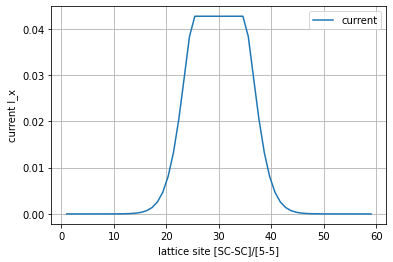

In [67]:
#l=1 on btoh gives peak on start of soc
#l=j at last id goves peak at the end of soc
#--> Need to always choose the one inside soc maybe?

site_x = np.linspace(0, system.L_x-1, system.L_x-1)
#plt.plot(site_x, np.real(current), label="real")
plt.plot(site_x[1:], np.real(current_jp)[1:], label="current")
plt.legend()
plt.xlabel("lattice site [SC-SC]/[5-5]")
plt.ylabel("current I_x")
plt.grid()
#plt.xlim(33,37)
#plt.savefig('current_sc_tole-6_LzLy=60.png', dpi=200, bbox_inches='tight')
plt.show()

<h2> Given that the current is correct; create plot for current as a function of phase in SNS-system.

In [ ]:
import sys
import numpy as np
sys.path.append("/Users/martinedh/Documents/NTNU/GitHub/FysMat/Prosjektoppgave")
from main import define_system, solve_and_test_small_system, solve_for_sns_system

#_________ Phase =  0.0 _________#


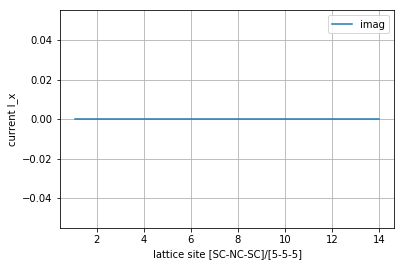

#_________ Phase =  0.3306939635357677 _________#


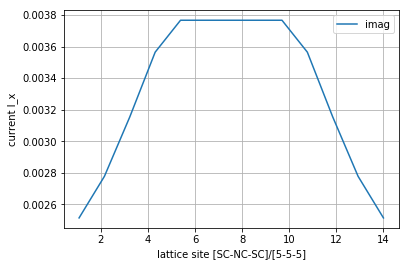

#_________ Phase =  0.6613879270715354 _________#


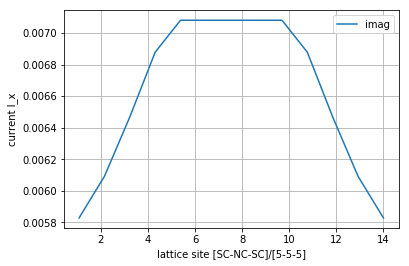

#_________ Phase =  0.992081890607303 _________#


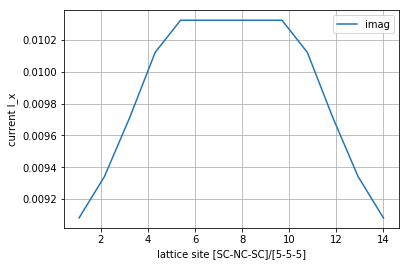

#_________ Phase =  1.3227758541430708 _________#


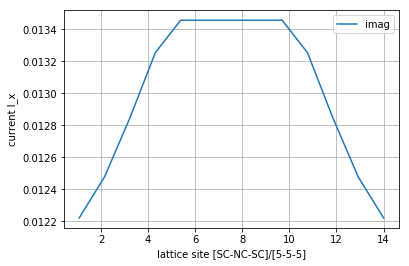

#_________ Phase =  1.6534698176788385 _________#


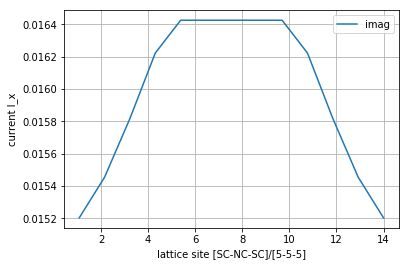

#_________ Phase =  1.984163781214606 _________#


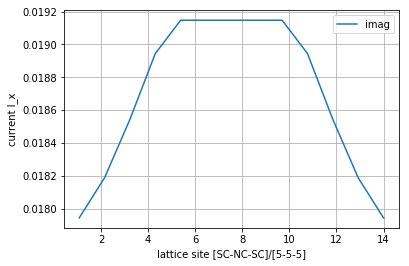

#_________ Phase =  2.3148577447503738 _________#


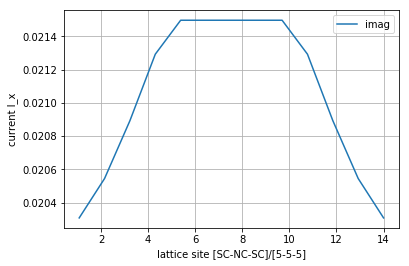

#_________ Phase =  2.6455517082861415 _________#


In [ ]:
current_for_phase, phase_arr = solve_for_sns_system()

In [ ]:
# e-4 is not enough, current e-1... need prop tole-5. 

In [ ]:
import matplotlib.pyplot as plt
plt.plot(phase_arr, current_for_phase/max(current_for_phase))
plt.xlabel("phase diff (phi)")
plt.ylabel("current I_x/I_c")
plt.title("Supercurrent SNS[5-5-5], TOL E-4 {L_y=20, L_z=20, mu_sc=0.9, mu_nc=0.9,mu_soc=0.85, u_sc=-4.2, beta=100}")
plt.savefig('current_sns_phase_change_5-5-5_tole_4.png', dpi=200, bbox_inches='tight')
plt.show()



In [ ]:
#https://numpy.org/doc/stable/reference/generated/numpy.savez.html
np.savez('sns_5_5_5_L20_u4_2_tole_4.npz', phase_arr, current_for_phase)
#npzfile = np.load(outfile)
#npzfile.files
#['arr_0', 'arr_1']
#npzfile['arr_0']

In [20]:
npzfile = np.load('sns_4_4_4_L20_u2_2.npz')

<h2> Given that the current is correct; create plot for current as a function of L (length of Ferromagnet) in SFS-system.

In [ ]:
import sys
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np

sys.path.append("/Users/martinedh/Documents/NTNU/GitHub/FysMat/Prosjektoppgave")
from main import solve_for_sfs_system

In [ ]:
current_for_L_f, L_f_arr = solve_for_sfs_system()

In [ ]:
plt.plot(L_f_arr, current_for_L_f)
plt.xlabel("Thickness of ferromagnet [L]")
plt.ylabel("current I_x")
plt.title("Supercurrent SFS[15-L-15], tol e-6 {L_y=60, L_z=60, mu_sc=0.9, mu_nc=0.9,mu_soc=0.85, u_sc=-2.2, h=[0,0,1], beta=100}")
plt.savefig('current_sfs_L_change_hz=1_15_L_15.png', dpi=200, bbox_inches='tight')
plt.show()

<h2> Given that the current is correct; create plot for current as a function of rashba(alpha) strength in S-HM-S-system.

In [ ]:
import sys
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np

sys.path.append("/Users/martinedh/Documents/NTNU/GitHub/FysMat/Prosjektoppgave")
from main import solve_for_shms_system

In [ ]:
current_for_L_hm, L_hm_arr = solve_for_shms_system(xz = True)

In [ ]:
plt.plot(L_hm_arr, current_for_L_hm)
plt.xlabel("strength of alpha n=z")
plt.ylabel("current I_x")
plt.title("Supercurrent S-HM-S[15-2-15], tol e-6 {L_y=50, L_z=50, mu_sc=0.9, mu_nc=0.9,mu_soc=0.85, u_sc=-2.2, alpha=[0,0,strength], beta=100}")
plt.savefig('current_shms_alpha_strength_change_n=z_15_2_15.png', dpi=200, bbox_inches='tight')
plt.show()

In [69]:
tmp = np.array([2,0.4,0])

In [73]:
np.linalg.norm(tmp)

2.039607805437114

In [74]:
np.sqrt(2**2+0.4**2)

2.039607805437114